In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import csv
from pandas.tseries.offsets import MonthEnd
from datetime import datetime, timedelta, date
import requests
import json 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.utils.multiclass import unique_labels

from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [15]:
MSFT_98_train = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_98_train_flat_df.csv", index_col=0)
MSFT_98_train = MSFT_98_train.reset_index(drop=True)


MSFT_98_test = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_98_test_flat_df.csv", index_col=0)
MSFT_98_test = MSFT_98_test.reset_index(drop=True)


MSFT_02_train = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_02_train_flat_df.csv", index_col=0)
MSFT_02_train = MSFT_02_train.reset_index(drop=True)


MSFT_02_test = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_02_test_flat_df.csv", index_col=0)
MSFT_02_test = MSFT_02_test.reset_index(drop=True)


MSFT_06_train = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_06_train_flat_df.csv", index_col=0)
MSFT_06_train = MSFT_06_train.reset_index(drop=True)


MSFT_06_test = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_06_test_flat_df.csv", index_col=0)
MSFT_06_test = MSFT_06_test.reset_index(drop=True)

MSFT_10_train = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_10_train_flat_df.csv", index_col=0)
MSFT_10_train = MSFT_10_train.reset_index(drop=True)


MSFT_10_test = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_10_test_flat_df.csv", index_col=0)
MSFT_10_test = MSFT_10_test.reset_index(drop=True)


MSFT_14_train = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_14_train_flat_df.csv", index_col=0)
MSFT_14_train = MSFT_14_train.reset_index(drop=True)


MSFT_14_test = pd.read_csv("/Users/fahad/project_repo/data/final/MSFT/MSFT_14_test_flat_df.csv", index_col=0)
MSFT_14_test = MSFT_14_test.reset_index(drop=True)


In [16]:
#get training and test labels for all the MSFT windows
y_train_98 = MSFT_98_train.Label
MSFT_98_train = MSFT_98_train.drop('Label', axis=1)


y_test_98 = MSFT_98_test.Label
MSFT_98_test = MSFT_98_test.drop('Label', axis=1)


y_train_02 = MSFT_02_train.Label
MSFT_02_train = MSFT_02_train.drop('Label', axis=1)


y_test_02 = MSFT_02_test.Label
MSFT_02_test = MSFT_02_test.drop('Label', axis=1)


y_train_06 = MSFT_06_train.Label
MSFT_06_train = MSFT_06_train.drop('Label', axis=1)


y_test_06 = MSFT_06_test.Label
MSFT_06_test = MSFT_06_test.drop('Label', axis=1)


y_train_10 = MSFT_10_train.Label
MSFT_10_train = MSFT_10_train.drop('Label', axis=1)



y_test_10 = MSFT_10_test.Label
MSFT_10_test = MSFT_10_test.drop('Label', axis=1)



y_train_14 = MSFT_14_train.Label
MSFT_14_train = MSFT_14_train.drop('Label', axis=1)


y_test_14 = MSFT_14_test.Label
MSFT_14_test = MSFT_14_test.drop('Label', axis=1)


# JOIN DATAFRAMES IN ORDER TO HAVE SUFFICIENT DATA TO TRAIN MODEL 

In [28]:
MSFT_98_02_train = MSFT_98_train.append(MSFT_02_train, ignore_index=True)

y_train_98_02 = y_train_98.append(y_train_02, ignore_index=True)

MSFT_98_02_test = MSFT_98_test.append(MSFT_02_test, ignore_index=True)

y_test_98_02 = y_test_98.append(y_test_02, ignore_index=True)





In [29]:
def make_timeseries_classifier(sample_num,window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=16):
    """:Return: a Keras Model for predicting the next value in a timeseries given a fixed-size lookback window of previous values.
    The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).
    :param int window_size: The number of previous timeseries values to use as input features.  Also called lag or lookback.
    :param int nb_input_series: The number of input timeseries; 1 for a single timeseries.
      The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; each instance is
      a 2D array of shape ``(window_size, nb_input_series)``.  For example, for `window_size` = 3 and `nb_input_series` = 1 (a
      single timeseries), one instance could be ``[[0], [1], [2]]``. See ``make_timeseries_instances()``.
    :param int nb_outputs: The output dimension, often equal to the number of inputs.
      For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.
    :param int filter_length: the size (along the `window_size` dimension) of the sliding window that gets convolved with
      each position along each instance. The difference between 1D and 2D convolution is that a 1D filter's "height" is fixed
      to the number of input timeseries (its "width" being `filter_length`), and it can only slide along the window
      dimension.  This is useful as generally the input timeseries have no spatial/ordinal relationship, so it's not
      meaningful to look for patterns that are invariant with respect to subsets of the timeseries.
    :param int nb_filter: The number of different filters to learn (roughly, input patterns to recognize).
    """
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size,nb_input_series)),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # To perform (binary) classification instead:
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    
    return model

In [30]:
MSFT_98_train.shape

(51, 360)

In [31]:
model_1 = make_timeseries_classifier(MSFT_98_02_train.shape[0],MSFT_98_02_train.shape[1],3)

/Users/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(360, 1), filters=16, kernel_size=3)`
/Users/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=16, kernel_size=3)`


In [32]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 358, 16)           64        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 179, 16)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 177, 16)           784       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 88, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1409      
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [45]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=0, patience=100)
mc = ModelCheckpoint('MSFT_98_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
cb_list = [es,mc]

In [46]:
X_train = np.array(MSFT_98_02_train).reshape((*MSFT_98_02_train.shape,1))
y_train = np.array(y_train_98_02).reshape((*y_train_98_02.shape,1))


In [35]:
history=model_1.fit(X_train, y_train,validation_split=0.10, epochs=1000,batch_size=1, verbose=1,
                    callbacks = cb_list)

Train on 81 samples, validate on 21 samples
Epoch 1/100
81/81 [==============================] - 1s 6ms/step - loss: 0.6980 - acc: 0.5185 - val_loss: 0.6754 - val_acc: 0.5714

Epoch 00001: val_acc improved from -inf to 0.57143, saving model to MSFT_98_model.h5
Epoch 2/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6843 - acc: 0.6049 - val_loss: 0.6733 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.57143 to 0.66667, saving model to MSFT_98_model.h5
Epoch 3/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6573 - acc: 0.7407 - val_loss: 0.6400 - val_acc: 0.7143

Epoch 00003: val_acc improved from 0.66667 to 0.71429, saving model to MSFT_98_model.h5
Epoch 4/100
81/81 [==============================] - 0s 2ms/step - loss: 0.6370 - acc: 0.6420 - val_loss: 0.6234 - val_acc: 0.6667

Epoch 00004: val_acc did not improve from 0.71429
Epoch 5/100
81/81 [==============================] - 0s 2ms/step - loss: 0.5731 - acc: 0.7160 - val_loss: 0.5852 - va

81/81 [==============================] - 0s 2ms/step - loss: 0.0654 - acc: 1.0000 - val_loss: 3.0155 - val_acc: 0.5714

Epoch 00045: val_acc did not improve from 0.76190
Epoch 46/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0710 - acc: 0.9877 - val_loss: 2.7327 - val_acc: 0.5714

Epoch 00046: val_acc did not improve from 0.76190
Epoch 47/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0587 - acc: 1.0000 - val_loss: 2.8258 - val_acc: 0.5714

Epoch 00047: val_acc did not improve from 0.76190
Epoch 48/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0416 - acc: 1.0000 - val_loss: 3.5338 - val_acc: 0.5714

Epoch 00048: val_acc did not improve from 0.76190
Epoch 49/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0479 - acc: 1.0000 - val_loss: 2.9025 - val_acc: 0.5714

Epoch 00049: val_acc did not improve from 0.76190
Epoch 50/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0532 - acc: 1.0000 - v

81/81 [==============================] - 0s 1ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 5.0555 - val_acc: 0.5714

Epoch 00090: val_acc did not improve from 0.76190
Epoch 91/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 4.8519 - val_acc: 0.5714

Epoch 00091: val_acc did not improve from 0.76190
Epoch 92/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 5.2676 - val_acc: 0.5714

Epoch 00092: val_acc did not improve from 0.76190
Epoch 93/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 5.0533 - val_acc: 0.5714

Epoch 00093: val_acc did not improve from 0.76190
Epoch 94/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 5.1576 - val_acc: 0.5714

Epoch 00094: val_acc did not improve from 0.76190
Epoch 95/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0029 - acc: 1.0000 - v

In [36]:
saved_model = load_model('MSFT_98_model.h5')


In [38]:
predictions = saved_model.predict_classes(np.array(MSFT_98_02_test).reshape((*MSFT_98_02_test.shape,1)),batch_size = MSFT_98_02_test.shape[0], verbose=1)


33/33 [==============================] - 0s 3ms/step


In [41]:
from sklearn.metrics import accuracy_score
print ("saved model acc: %s" % accuracy_score(y_test_98_02, predictions))
# accuracy: (tp + tn) / (p + n)

# precision tp / (tp + fp)
precision = precision_score(y_test_98_02, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_98_02, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_98_02, predictions)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test_98_02, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test_98_02, predictions)
print('ROC AUC: %f' % auc)

saved model acc: 0.7878787878787878
Precision: 0.882353
Recall: 0.750000
F1 score: 0.810811
Cohens kappa: 0.573013
ROC AUC: 0.798077


W0815 10:50:52.067407 4549211584 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


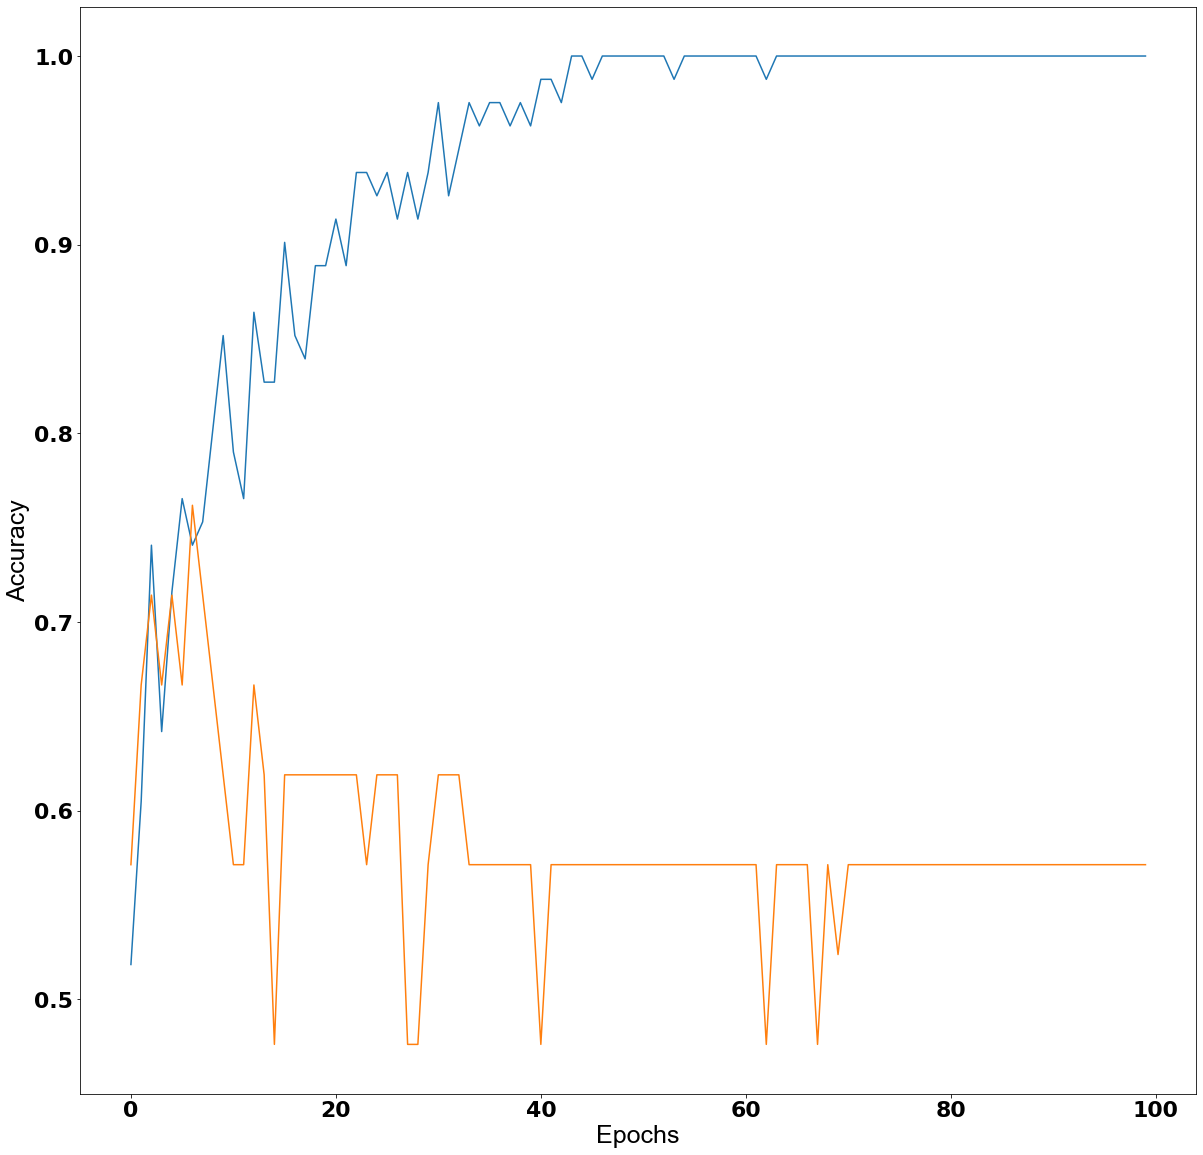

In [42]:
#plot the accuracy of the training set  and the validation set of the model
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
axis_font = {'fontname':'Arial', 'size':'25'}

plt.figure(figsize=[20,20])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy', **axis_font)
plt.xlabel('Epochs', **axis_font)

plt.show()

In [43]:
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype("float")/ cm.sum(axis=1)[:,np.newaxis]
        print ("Normalised confusion matrix")
    else:
        print ("Confusion matrix, without normalisation")
        
    print (cm)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
        horizontalalignment = "center",
        color="white" if cm[i,j] > thresh else "black" )
        
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    
    




W0815 10:51:58.856551 4549211584 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
W0815 10:51:58.865958 4549211584 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
W0815 10:51:58.969830 4549211584 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Confusion matrix, without normalisation
[[11  2]
 [ 5 15]]


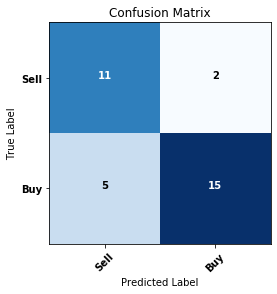

In [44]:
cm = confusion_matrix(y_test_98_02, predictions)
cm_labels = ['Sell', 'Buy']
plot_confusion_matrix(cm, cm_labels, title="Confusion Matrix")

In [ ]:
def make_timeseries_classifier(sample_num,window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=16):
    """:Return: a Keras Model for predicting the next value in a timeseries given a fixed-size lookback window of previous values.
    The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).
    :param int window_size: The number of previous timeseries values to use as input features.  Also called lag or lookback.
    :param int nb_input_series: The number of input timeseries; 1 for a single timeseries.
      The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; each instance is
      a 2D array of shape ``(window_size, nb_input_series)``.  For example, for `window_size` = 3 and `nb_input_series` = 1 (a
      single timeseries), one instance could be ``[[0], [1], [2]]``. See ``make_timeseries_instances()``.
    :param int nb_outputs: The output dimension, often equal to the number of inputs.
      For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.
    :param int filter_length: the size (along the `window_size` dimension) of the sliding window that gets convolved with
      each position along each instance. The difference between 1D and 2D convolution is that a 1D filter's "height" is fixed
      to the number of input timeseries (its "width" being `filter_length`), and it can only slide along the window
      dimension.  This is useful as generally the input timeseries have no spatial/ordinal relationship, so it's not
      meaningful to look for patterns that are invariant with respect to subsets of the timeseries.
    :param int nb_filter: The number of different filters to learn (roughly, input patterns to recognize).
    """
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size,nb_input_series)),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # To perform (binary) classification instead:
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    
    return model